In [1]:
import json
import os, sys
import pickle
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns
import ROOT as rt


## user define
sys.path.append(".")
sys.path.append("./Utils")
from Plotter import HistStack
from CommonTrain import *
from Model import Seq

2023-02-07 15:01:59.406999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorfl

Welcome to JupyROOT 6.26/08


# Set config

In [2]:
setting={}
with open('config/Settrain.json') as json_file:
    data = json.load(json_file)
    setting=data
INPUTDIR = setting["INPUTDIR"]
VERSION = setting["VERSION"]
SIGNAL_MASSES = ["Zp-1700_CH-345", "Zp-2900_CH-345", "Zp-4100_CH-345", "Zp-2900_CH-1095", "Zp-4100_CH-1095", "Zp-4100_CH-1845"]

CHANNEL="ee"
ERA="17"

# Load data

In [3]:
time_stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")

with open(INPUTDIR+'/ee16pre/nested_dic_df.pkl', 'rb') as f:
    nested_dic_df = pickle.load(f)
with open(INPUTDIR+'/ee16post/nested_dic_df.pkl', 'rb') as f:
    nested_dic_df1 = pickle.load(f) 
with open(INPUTDIR+'/ee17/nested_dic_df.pkl', 'rb') as f:
    nested_dic_df2 = pickle.load(f) 
with open(INPUTDIR+'/ee18/nested_dic_df.pkl', 'rb') as f:
    nested_dic_df3 = pickle.load(f)     

dic_df_all = [nested_dic_df['raw'], nested_dic_df1['raw'], nested_dic_df2['raw'], nested_dic_df3['raw']]
dic_df_met_u_all = [nested_dic_df['met_u'], nested_dic_df1['met_u'], nested_dic_df2['met_u'], nested_dic_df3['met_u']]
dic_df_met_d_all = [nested_dic_df['met_d'], nested_dic_df1['met_d'], nested_dic_df2['met_d'], nested_dic_df3['met_d']]

selected_columns = [
#                     'MC1C1_pre', 'H3PP_pre', 'H3TPP_pre', 
                    'pt_lead_pre', 'mass_pre', # by auc rank
                    'MT_pre', 'pt_trail_pre', 'Zpt_pre', 'dRll_pre', 'PuppiMET_pre',
                    'dPhilMET_pre', 'dPhillMET_pre', 'U_pre', 'dPhill_pre', 'MT2_pre',
                    'JZB_pre']

dic_df, dic_df_met_u, dic_df_met_d, dic_df_train = [{} for _ in range(4)]

for key in dic_df_all[0]:
    list_raw, list_met_u, list_met_d, list_train = [[] for _ in range(4)]
    for i in range(4):
        try:
            list_raw.append(dic_df_all[i][key])
            list_met_u.append(dic_df_met_u_all[i][key])
            list_met_d.append(dic_df_met_d_all[i][key])
            list_train.append(dic_df_all[i][key][selected_columns])
        except:
            print("missing:", key)
    dic_df[key]=pd.concat(list_raw, ignore_index=True)
    dic_df_met_u[key]=pd.concat(list_met_u, ignore_index=True)
    dic_df_met_d[key]=pd.concat(list_met_d, ignore_index=True)
    dic_df_train[key]=pd.concat(list_train, ignore_index=True)

print(dic_df["TT"].columns)
print(dic_df_met_u["TT"].columns)

missing: Zp-1700_CH-345
missing: Zp-1700_CH-595
missing: Zp-1700_CH-595
missing: Zp-2500_CH-845
missing: Zp-2100_CH-345
missing: Zp-2900_CH-595
missing: Zp-3300_CH-845
missing: Zp-3300_CH-845
missing: Zp-3300_CH-845
Index(['MET_pre', 'MET_phi_pre', 'PuppiMET_pre', 'PuppiMET_phi_pre',
       'mass_pre', 'pt_lead_pre', 'pt_trail_pre', 'eta_lead_pre',
       'eta_trail_pre', 'phi_lead_pre', 'phi_trail_pre', 'U_pre', 'JZB_pre',
       'dPhill_pre', 'dPhilMET_pre', 'MT_pre', 'MT2_pre', 'Zpt_pre',
       'dRll_pre', 'dPhillMET_pre', 'nbjet_pre', 'nbjetflav_pre',
       'btag_score_pre', 'nvertices_pre', 'genweight_u_pre', 'genweight_d_pre',
       'genweight_pre', 'puweight_pre', 'puweight_u_pre', 'puweight_d_pre',
       'l1prefiring_pre', 'l1prefiring_u_pre', 'l1prefiring_d_pre',
       'effSF_pre', 'effSF_u_pre', 'effSF_d_pre', 'topSF_pre', 'topSFAlt_pre',
       'MC1C1_pre', 'H3PP_pre', 'H3TPP_pre', 'pdf1_ee_pre', 'pdf2_ee_pre',
       'pdf3_ee_pre', 'pdf4_ee_pre', 'pdf5_ee_pre', 'pdf6_e

In [4]:
def get_pnn(dic_df, signal_masses):
    # x: sig and all bkgs concatenated
    
    w_sig = np.empty(0)
    zp_mass = []
    ch_mass = []
    prob = np.full(len(signal_masses), float(1/len(signal_masses)))
    print(prob)
    for i, m in enumerate(signal_masses):
        masses = m.split('_')
        zp_m = masses[0].split('-')
        zp_m = zp_m[1]
        zp_mass.append(int(zp_m))
        ch_m = masses[1].split('-')
        ch_m = ch_m[1]
        ch_mass.append(int(ch_m))
        x_raw = dic_df[m].copy(deep=True)
        x_tmp = x_raw[selected_columns]
        x_tmp['zp_m'] = np.full(x_tmp.shape[0], int(zp_m))
        x_tmp['ch_m'] = np.full(x_tmp.shape[0], int(ch_m))
#         x_tmp = x_raw.sample(30000)
        if i==0:
            x = x_tmp
        else:
            x = np.concatenate([x, x_tmp], axis=0)
        w_df = x_raw["weight"].copy(deep=True)
        w_df/=w_df.iat[0] # sig weight ~1
        w_sig = np.append(w_sig, w_df.to_numpy())            
    print(zp_mass)
#     w_sig = np.empty(0)
    w_bkg = np.empty(0)
    w_bkg_raw = np.empty(0)
    for k in dic_df:
        # skip data, signal
        if "Data" in k or "Zp" in k:
            continue
        w_df = dic_df[k]["weight"].copy(deep=True)
        # backgrounds
        x_tmp = dic_df[k][selected_columns]
        x_tmp['zp_m'] = np.random.choice(zp_mass, x_tmp.shape[0], p=prob)
        x_tmp['ch_m'] = np.random.choice(ch_mass, x_tmp.shape[0], p=prob)
        x = np.concatenate([x, x_tmp], axis=0)
        # weight customization
        if k=="WW" or k=="DY":
            w_bkg = np.append(w_bkg, 10*w_df.to_numpy())
            w_bkg_raw = np.append(w_bkg_raw, w_df.to_numpy())
        else:    
            w_bkg = np.append(w_bkg, w_df.to_numpy())     
            w_bkg_raw = np.append(w_bkg_raw, w_df.to_numpy())  
            
    print("unweighted #sig:", w_sig.shape[0])
    print("unweighted #all bkg:", w_bkg.shape[0])
    print("weighted #sig:", np.sum(w_sig))
    print("weighted #all bkg:", np.sum(w_bkg))
    print("weighted #all bkg (no custum):", np.sum(w_bkg_raw))

    tot_sig = w_sig.shape[0]
    tot_bkgs = x.shape[0] - tot_sig        
    y_sig = np.full((tot_sig,1), 1)
    y_bkgs = np.full((tot_bkgs,1), 0) 

    # class weight: scale to bkg
    classweight = np.sum(w_bkg)/np.sum(w_sig)
    w_sig *= classweight
    
    print("scaled #sig:", np.sum(w_sig))
    print("scaled #all bkg:", np.sum(w_bkg))    
    
    w = np.concatenate((w_sig, w_bkg), axis=0)
    w_raw = np.concatenate((w_sig, w_bkg_raw), axis=0)
    y = np.concatenate((y_sig, y_bkgs), axis=0) 
    
    return x, y, w, w_raw

# get_binary("Zp-2500")
get_pnn(dic_df, SIGNAL_MASSES)



[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


/tmp/ipykernel_4897/3770684230.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tmp['zp_m'] = np.full(x_tmp.shape[0], int(zp_m))
/tmp/ipykernel_4897/3770684230.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tmp['ch_m'] = np.full(x_tmp.shape[0], int(ch_m))


[1700, 2900, 4100, 2900, 4100, 4100]


/tmp/ipykernel_4897/3770684230.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tmp['zp_m'] = np.random.choice(zp_mass, x_tmp.shape[0], p=prob)
/tmp/ipykernel_4897/3770684230.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tmp['ch_m'] = np.random.choice(ch_mass, x_tmp.shape[0], p=prob)


unweighted #sig: 319759
unweighted #all bkg: 932476
weighted #sig: 383787.79069343803
weighted #all bkg: 51065.366263796896
weighted #all bkg (no custum): 32131.932339260304
scaled #sig: 51065.36626379689
scaled #all bkg: 51065.366263796896


(array([[ 134.75650024,  222.27891541,  243.71844482, ...,   20.05602264,
         1700.        ,  345.        ],
        [ 336.46405029,  649.44720459,  470.86071777, ..., -109.1556015 ,
         1700.        ,  345.        ],
        [ 298.73327637,  515.831604  ,  539.34509277, ..., -243.61245728,
         1700.        ,  345.        ],
        ...,
        [ 211.89761353,  230.40103149,  208.48535156, ...,  102.65013123,
         1700.        , 1095.        ],
        [ 504.00720215,  504.95288086,  922.22149658, ..., -347.89117432,
         2900.        , 1845.        ],
        [  92.84465027,  108.6541748 ,  200.52006531, ...,  150.61912537,
         2900.        ,  345.        ]]),
 array([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]]),
 array([0.13305626, 0.14214757, 0.1355198 , ..., 0.59282799, 0.60589966,
        0.49962265]),
 array([0.13305626, 0.14214757, 0.1355198 , ..., 0.0592828 , 0.06058997,
        0.04996227]))

In [5]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# Training

[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


/tmp/ipykernel_4897/3770684230.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tmp['zp_m'] = np.full(x_tmp.shape[0], int(zp_m))
/tmp/ipykernel_4897/3770684230.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tmp['ch_m'] = np.full(x_tmp.shape[0], int(ch_m))


[1700, 2900, 4100, 2900, 4100, 4100]


/tmp/ipykernel_4897/3770684230.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tmp['zp_m'] = np.random.choice(zp_mass, x_tmp.shape[0], p=prob)
/tmp/ipykernel_4897/3770684230.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tmp['ch_m'] = np.random.choice(ch_mass, x_tmp.shape[0], p=prob)


unweighted #sig: 319759
unweighted #all bkg: 932476
weighted #sig: 383787.79069343803
weighted #all bkg: 51065.366263796896
weighted #all bkg (no custum): 32131.932339260304
scaled #sig: 51065.36626379689
scaled #all bkg: 51065.366263796896
mean: [ 2.14741947e+02  3.29297428e+02  4.13014275e+02  1.08614300e+02
  1.63674214e+02  2.65322163e+00  2.04053123e+02  2.06913975e+00
  2.11001927e+00  1.46228448e+02  2.30868569e+00  7.79717374e+01
 -1.74457657e+01  3.35212632e+03  8.72935052e+02]
var: [2.98074861e+04 7.35285930e+04 1.34085280e+05 8.79025265e+03
 2.24542879e+04 4.89727061e-01 2.14288145e+04 9.72239986e-01
 9.56159278e-01 1.67995852e+04 5.32857361e-01 1.26160949e+04
 3.67464655e+04 7.56167881e+05 3.18584758e+05]
Epoch 1/10
1223/1223 [==============================] - 154s 124ms/step - loss: 0.0565 - accuracy: 0.7532 - val_loss: 0.0536 - val_accuracy: 0.8340
Epoch 2/10
1223/1223 [==============================] - 5s 4ms/step - loss: 0.0520 - accuracy: 0.7913 - val_loss: 0.0480 - va

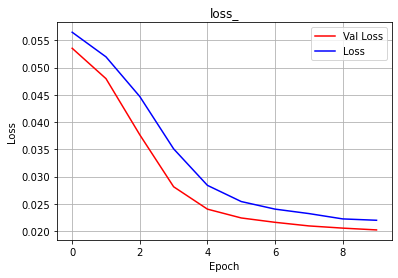

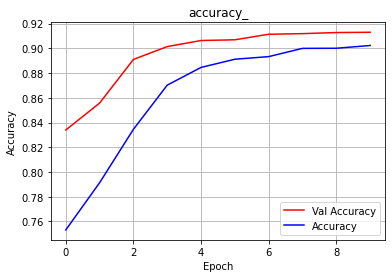

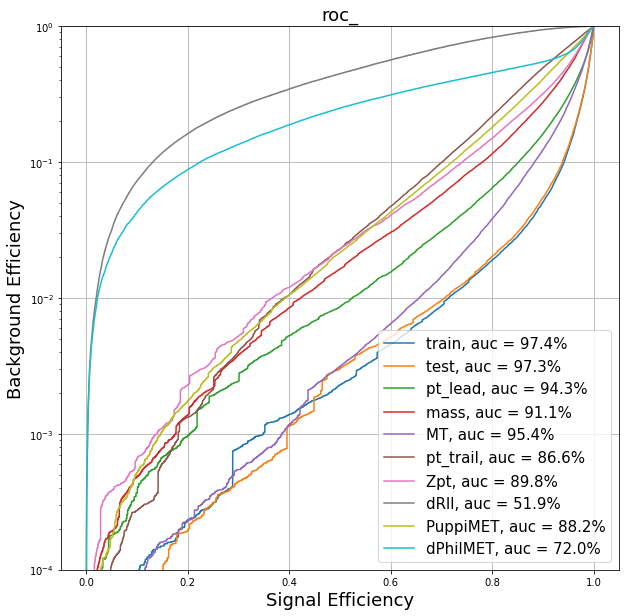

2023-02-07 15:02:52.344400: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

In [6]:
OUTDIR = 'Outputs/'+CHANNEL
os.system('mkdir -p '+OUTDIR)
nbin=20

# %matplotlib inline
rt.gROOT.SetBatch(rt.kTRUE)

file_postfix = 'PNN_'+VERSION

x, y, w, w_raw = get_pnn(dic_df, SIGNAL_MASSES)

#-- binalize --#
lb = preprocessing.LabelBinarizer()
lb.fit(y)
lb.classes_
y=lb.transform(y)

#-- split train, test --#
x_train, x_test, y_train, y_test, w_train, w_test, w_train_raw, w_test_raw = train_test_split(x, y, w, w_raw, test_size=0.5)

#-- scale --#
Transformer = preprocessing.StandardScaler()
Transformer.fit(x)
print('mean:',Transformer.mean_)
print('var:',Transformer.var_)        
x_train = Transformer.transform(x_train)
x_test = Transformer.transform(x_test)
pickle.dump(Transformer, open(OUTDIR+'/scaler_'+file_postfix+'.pkl','wb'))

#-- training --#
epochs = 250
batch = 512
opt = keras.optimizers.SGD(learning_rate=0.01, decay=1e-6)
early_stopping = keras.callbacks.EarlyStopping(patience=20)

n_input = dic_df_train[key].shape[1]
model = Seq(n_input, n_input, 1, tf.nn.sigmoid)
model.compile(loss='binary_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

log_dir = "logs/fit/mm_multiclass_" + time_stamp
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

dic_nested_roc = {}        
dic_nested_soverb = {}        
for i in range(1): # number of trials
    history = model.fit(x_train, y_train, verbose=1,
                     epochs=epochs, 
                     batch_size=batch,  
                     #class_weight={0:classweight_sig, 1:classweight_bkgs}, 
                     sample_weight=w_train,   
                     validation_data=(x_test,y_test,w_test), 
                     #validation_data=(x_test,y_test), 
                     callbacks=[early_stopping, tensorboard_callback])


    #-- evaluate --#
    TrainScore = model.evaluate(x_train, y_train, batch_size=x_train.shape[0], verbose=0)
    TestScore = model.evaluate(x_test, y_test, batch_size=x_test.shape[0], verbose=0)
    print('Train Loss :', TrainScore[0])
    print('Train Acc :', TrainScore[1])
    print('Test Loss :', TestScore[0])
    print('Test Acc :', TestScore[1])
    train_predict = model.predict(x_train, batch_size=x_train.shape[0])
    test_predict = model.predict(x_test, batch_size=x_test.shape[0])

    #-- save --#
    model.save(OUTDIR+'/model_'+file_postfix)
    with open(OUTDIR+'/history_'+file_postfix, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)        
    # loss
    pl2 = save_loss('', history, file_name=OUTDIR+'/loss_'+file_postfix+'.pdf')
    # accuracy
    pl3 = save_accuracy('', history, file_name=OUTDIR+'/accuracy_'+file_postfix+'.pdf')
    
    df_val = pd.DataFrame()
    df_val['y_test'] = y_test[:,0]
    df_val['test_predict'] = test_predict
    df_val['w_test_raw'] = w_test_raw
    df_tr = pd.DataFrame()
    df_tr['y_train'] = y_train[:,0]
    df_tr['train_predict'] = train_predict
    df_tr['w_train_raw'] = w_train_raw
        
    pl4, tpr, fpr, auc, tpr1, fpr1, auc1=save_roc('', df_val, df_tr, x_train, selected_columns, file_name=OUTDIR+'/roc_'+file_postfix+'.pdf')
    dic_roc = {}
    dic_roc['tpr'] = tpr
    dic_roc['fpr'] = fpr
    dic_roc['auc'] = auc
    dic_nested_roc['trial_'+str(i)] = dic_roc

with open(OUTDIR+'/nested_dic_roc_trials'+file_postfix+'.pkl', 'wb') as f:
    pickle.dump(dic_nested_roc, f)  
           